<a href="https://colab.research.google.com/github/kenwkliu/ideas/blob/master/colab/NewsSentimentSmallLanguageModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

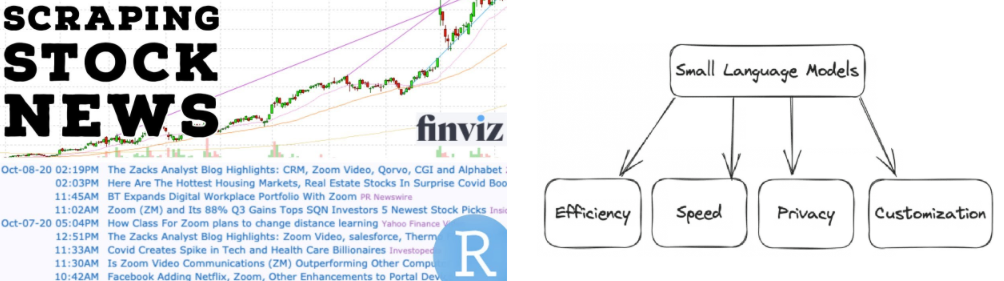

In [ ]:
#@title Import libraries and helper functions
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import requests, datetime
import pandas as pd
import numpy as np
from textblob import TextBlob
from transformers import pipeline
from bs4 import BeautifulSoup as bs

import matplotlib.pyplot as plt
%matplotlib inline

# Enable Google interactive table
from google.colab import data_table
data_table.enable_dataframe_formatter()

agent_info = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'}

# Convert the sentiment label
# from: {-1:Negative, 0:Neutral, 1:Positive}
#   to: { 0:Negative, 2:Neutral, 1:Positive}
def convertSentimentLabel(label):
  if label == 0: return -1
  elif label == 2: return 0
  else: return label


# combine multiple words into one single word
# e.g. very good -> very_good
def combineWord(words):
  combined = ""
  for word in words:
    combined += word + "_"

  return combined[:len(combined)-1]


def convertTextBlobSentimentPolarity(polarity, positiveThreshod=0.1, negativeThreshod=-0.1):
  if polarity < negativeThreshod: return -1
  elif polarity > positiveThreshod: return 1
  else: return 0


# get the sentiment polarity and assessment from Textblob
def getTextBlobSentiments(content):
  tb = TextBlob(content)
  assessmentsList = []

  for assessments in tb.sentiment_assessments.assessments:
    assessmentsList.append((combineWord(assessments[0]), assessments[1]))

  return convertTextBlobSentimentPolarity(tb.polarity), tb.polarity, assessmentsList


def getLmScore(lm):
    x = lm[0]

    if x['label'] =="neutral":
        return 0
    elif x['label']  =="positive":
        return 1
    elif x['label']  =="negative":
        return -1

Sentiment analysis by TextBlob (**rule and pattern** based)

**polarity** is within the range **[-1.0, 1.0]** where -1 is very negative and 1.0 is very positive

https://github.com/sloria/TextBlob/blob/eb08c120d364e908646731d60b4e4c6c1712ff63/textblob/en/en-sentiment.xml


In [ ]:
# Use a tradition rule-based sentiment engine textblob
sentence = 'This demo is interesting'

print(sentence)
tb = TextBlob(sentence)
print('polarity=', tb.polarity)
tb.sentiment_assessments

In [ ]:
#@title Load the small language model
lm_model = 'mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis' # @param ["mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"] {allow-input: true}

lm_sentiment = pipeline("text-classification", model=lm_model)

In [ ]:
print(getLmScore(lm_sentiment("The profit is great")))
print(getLmScore(lm_sentiment("The profit is the same")))
print(getLmScore(lm_sentiment("The profit is bad")))

In [ ]:
#@title Sample news data source with labelled sentiments polarity (-1: Negative, 0: Neutral, 1: Positive)

splits = {'train': 'sent_train.csv', 'validation': 'sent_valid.csv'}
df = pd.read_csv("hf://datasets/zeroshot/twitter-financial-news-sentiment/" + splits["train"])

# Convert the sentiment label to {-1:Negative, 0:Neutral, 1:Positive}
df['polarity'] = df['label'].apply(convertSentimentLabel)
df[['text', 'polarity']]

In [ ]:
#@title Apply Textblob to each of the news header for the polarity

df['textblob_polarity'], df['textblob_sentiment'], df['textblob_assessments'] = zip(*df['text'].apply(getTextBlobSentiments))
df[['text', 'polarity', 'textblob_polarity', 'textblob_assessments']]

In [ ]:
#@title Use the Language model to determine the sentiments of each news
#df['lm_polarity'] = df['text'].apply(lambda x: getLmScore(lm_sentiment(x)))
#df[['text', 'polarity', 'lm_polarity', 'textblob_polarity', 'textblob_sentiment', 'textblob_assessments']]

# To save time, use the saved results
df = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/refs/heads/master/colab/data/NewsSentimentSmallLanguageModel.csv')

df['lm'] = (df['polarity'] == df['lm_polarity']).astype(int)
df['textblob'] = (df['polarity'] == df['textblob_polarity']).astype(int)
df[['text', 'polarity', 'lm_polarity', 'textblob_polarity', 'textblob_assessments']]

In [ ]:
#@title Summarize the accuracy
print("Small LLM: {}".format(df['lm'].sum() / len(df['lm'])))
print("Textblob : {}".format(df['textblob'].sum() / len(df['lm'])))

In [ ]:
#@title Select a stock ticker to get the URL for Webscraping

ticker = 'NVDA' # @param ["NVDA", "AAPL", "HSBC", "BABA"] {allow-input: true}

# Web scrape the news

finviz_url = "https://finviz.com/quote.ashx?t="


news_tables = {}
url = finviz_url + ticker
print(url)
t_content = requests.get(url, headers = agent_info)
content_bs = bs(t_content.content, "html")
news_tab = content_bs.find(id="news-table")
news_tables[ticker] =news_tab

In [ ]:
#@title Webscrape the news headline from the URL

table_array = []

for name, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
        try:
          #headline
          text_content = x.a.get_text()
          #dates
          date_content = x.td.text.split()

          if len(date_content) == 1:
              time = date_content[0]
          else:
              date= date_content[0]
              time = date_content[1]

          table_array.append([name,date, time, text_content])

        except:
          continue

table_news = pd.DataFrame(table_array, columns=["Ticker","Date","Time","Headline"])

table_news['Date'] = np.where(table_news['Date']=="Today", datetime.date.today(), table_news['Date'])
table_news['Date'] = pd.to_datetime(table_news['Date']).dt.date

table_news

In [ ]:
#@title Use the small Language model to determine the sentiments of each news

table_news['polarity'] = table_news['Headline'].apply(lambda x: getLmScore(lm_sentiment(x)))
table_news

In [ ]:
#@title Sentiment Distribution

import plotly.express as px

df_pie = table_news.groupby('polarity').count().reset_index()
df_pie.rename(columns={'Headline' : 'count'}, inplace=True)

fig = px.pie(df_pie, values='count', names='polarity', title='Sentiment Distribution')
fig.show()

Based on the recent news headlines, use the sentiment analysis to determine **buy/sell signal** of a particular stock


*   if positive sentiment > 40% = Bull -> Buy (Long)
*   if negative sentiment > 40% = Bear -> Sell (Short)
*   Otherwise, takes no action


Additionally, this sentiment analysis can serve as a **supplementary** information alongside the existing indicators (e.g., EMA, RSI) to **confirm signals**.

For example, with the EMA, when the short-term moving average is above the long-term moving average, it typically indicates a short-term upward price trend. When combined with positive news sentiment, this reinforces the belief in a bullish market.

